In [4]:
from utils.data_loader import *
from utils.mobilenet_v2_tsm import MobileNetV2
from utils.transform import get_transform
from torchvision.transforms import *
import torch

In [6]:
csv_path_input = './20bn-jester-v1/annotations/Validation.csv'
csv_path_labels = './20bn-jester-v1/annotations/Labels.csv'
data_root = './20bn-jester-v1/videos/archive/20BN-JESTER/Validation'
model_path = './models/mobilenetv2_jester_online.pth.tar'

In [3]:
transform = get_transform()

loader = VideoFolder(root=data_root,
                     csv_file_input=csv_path_input,
                     csv_file_labels=csv_path_labels,
                     clip_size=20,
                     nclips=1,
                     step_size=1,
                     is_val=False,
                     transform=transform,
                     loader=default_loader)

C:\Users\KingO\anaconda3\envs\cv\lib\site-packages\torchvision\transforms\transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
C:\Users\KingO\anaconda3\envs\cv\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [4]:
loader[0][1]

23

In [7]:
net = MobileNetV2(n_class=27)
net.load_state_dict(torch.load(model_path))
net = net.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


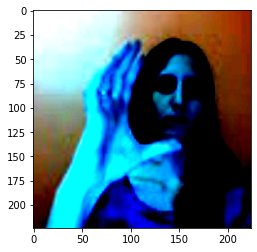

In [8]:
import matplotlib.pyplot as plt
frame = loader[0][0][2].numpy()
frame = np.transpose(frame, axes=[1, 2, 0])
plt.imshow(frame)

plt.show()

In [12]:
len(loader[3][0])

20

In [9]:
results = []
buffer = (
            torch.zeros([1, 3, 56, 56], device='cuda'),
            torch.zeros([1, 4, 28, 28], device='cuda'),
            torch.zeros([1, 4, 28, 28], device='cuda'),
            torch.zeros([1, 8, 14, 14], device='cuda'),
            torch.zeros([1, 8, 14, 14], device='cuda'),
            torch.zeros([1, 8, 14, 14], device='cuda'),
            torch.zeros([1, 12, 14, 14], device='cuda'),
            torch.zeros([1, 12, 14, 14], device='cuda'),
            torch.zeros([1, 20, 7, 7], device='cuda'),
            torch.zeros([1, 20, 7, 7], device='cuda')
        )
for i in range(20):
    img = loader[3][0][i]   
    input_var = img.view(1, 3, img.size(1), img.size(2)).cuda()
    inputs = (input_var,) + buffer
    output = net(*inputs)
    results.append(output[0].cpu().detach().numpy())
    buffer = output[1:]

In [10]:
np.mean(np.array(results),0)

array([[  2.3277602 ,   2.8196597 , -21.007818  ,   0.0279596 ,
          0.56100017,   1.0695238 ,   2.894709  ,  -2.127373  ,
         -2.669296  ,   3.9676292 ,  -1.9176706 ,   2.3414168 ,
         -0.5084556 ,   0.5933889 ,  -3.251472  ,  -1.0468901 ,
          1.7093213 ,  -0.50157064,   0.3984862 ,  -0.05909434,
         -3.8359852 ,   6.07014   ,   5.3910847 ,   3.169738  ,
          1.3113463 ,   2.5512106 ,  -0.28272104]], dtype=float32)

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.cpu().topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [66]:
def validate(val_loader, model, criterion, class_to_idx=None):
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):

            input, target = input.to('cuda'), torch.tensor([target]).to('cuda')

            # compute output and loss
            results = torch.empty(0,device='cuda')
            buffer = (
                        torch.zeros([1, 3, 56, 56], device='cuda'),
                        torch.zeros([1, 4, 28, 28], device='cuda'),
                        torch.zeros([1, 4, 28, 28], device='cuda'),
                        torch.zeros([1, 8, 14, 14], device='cuda'),
                        torch.zeros([1, 8, 14, 14], device='cuda'),
                        torch.zeros([1, 8, 14, 14], device='cuda'),
                        torch.zeros([1, 12, 14, 14], device='cuda'),
                        torch.zeros([1, 12, 14, 14], device='cuda'),
                        torch.zeros([1, 20, 7, 7], device='cuda'),
                        torch.zeros([1, 20, 7, 7], device='cuda')
                    )
            for j in range(len(input)):
                img = input[j]   
                input_var = img.view(1, 3, img.size(1), img.size(2)).cuda()
                inputs = (input_var,) + buffer
                output = model(*inputs)
                results = torch.cat((results, output[0]), 0)
                buffer = output[1:]  
            
            output = torch.unsqueeze(torch.mean(results,0),0)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(output.detach(), target.detach().cpu(), topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))
            top5.update(prec5.item(), input.size(0))

            if i%200==0:
                print('Test: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                          i, len(val_loader), loss=losses, top1=top1, top5=top5))

        print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))


        return losses.avg, top1.avg, top5.avg

In [67]:
validate(loader, net, criterion = torch.nn.CrossEntropyLoss())

Test: [0/7047]	Loss 23.3002 (23.3002)	Prec@1 0.000 (0.000)	Prec@5 100.000 (100.000)
Test: [200/7047]	Loss 24.4399 (14.8748)	Prec@1 0.000 (13.433)	Prec@5 0.000 (50.249)
Test: [400/7047]	Loss 0.0189 (14.6373)	Prec@1 100.000 (12.469)	Prec@5 100.000 (51.122)
Test: [600/7047]	Loss 25.4723 (14.1567)	Prec@1 0.000 (14.476)	Prec@5 0.000 (52.413)
Test: [800/7047]	Loss 22.4792 (14.4954)	Prec@1 0.000 (15.356)	Prec@5 0.000 (52.310)
Test: [1000/7047]	Loss 21.7022 (14.5242)	Prec@1 0.000 (15.385)	Prec@5 100.000 (52.448)
Test: [1200/7047]	Loss 0.4420 (14.7037)	Prec@1 100.000 (15.820)	Prec@5 100.000 (51.790)
Test: [1400/7047]	Loss 17.1191 (14.6397)	Prec@1 0.000 (15.489)	Prec@5 100.000 (52.034)
Test: [1600/7047]	Loss 4.0422 (14.6344)	Prec@1 0.000 (15.240)	Prec@5 100.000 (51.530)
Test: [1800/7047]	Loss 27.8991 (14.4602)	Prec@1 0.000 (15.325)	Prec@5 100.000 (52.304)
Test: [2000/7047]	Loss 27.1543 (14.5889)	Prec@1 0.000 (15.242)	Prec@5 0.000 (51.974)
Test: [2200/7047]	Loss 13.2383 (14.5666)	Prec@1 0.000 (15

KeyboardInterrupt: 

In [15]:
output = torch.tensor([[-0.1136, -0.2269,  0.1137, -0.1246,  0.0748, -0.0490,  0.1460,  0.1486,
          0.0854, -0.2382,  0.3756, -0.0691,  0.1050,  0.1939, -0.1566,  0.0517,
         -0.2876, -0.3588,  0.0863, -0.0688, -0.1453,  0.0519,  0.1775,  0.0639,
         -0.0731, -0.0213,  0.1363],
        [-0.1138, -0.2076,  0.0753, -0.1510,  0.0800, -0.0422,  0.1287,  0.1702,
          0.1172, -0.2148,  0.3811, -0.0767,  0.1276,  0.1951, -0.1567,  0.0707,
         -0.2953, -0.3850,  0.1074, -0.0744, -0.1522,  0.0719,  0.1803,  0.0671,
         -0.0490, -0.0114,  0.1523],
        [-0.0176, -0.2540,  0.1002, -0.1734,  0.1065, -0.0512,  0.1538,  0.1918,
          0.1606, -0.2086,  0.3723, -0.1270,  0.0980,  0.1642, -0.1733,  0.0857,
         -0.3411, -0.4426,  0.1194, -0.1570, -0.1980,  0.1252,  0.2436,  0.1031,
          0.0013,  0.0217,  0.1527]], device='cuda:0')

target =torch.tensor([ 8, 10, 13])

In [16]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.cpu().topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [17]:
_, pred = a.cpu().topk(5, 1, True, True)
pred = pred.t()

In [18]:
pred

tensor([[10, 10, 10],
        [13, 13, 22],
        [22, 22,  7],
        [ 7,  7, 13],
        [ 6, 26,  8]])

In [25]:
correct = pred.eq(target.view(1, -1).expand_as(pred))
correct

tensor([[False,  True, False],
        [False, False, False],
        [False, False, False],
        [False, False,  True],
        [False, False, False]])

In [26]:
correct[:1].reshape(-1).float().sum(0)

tensor(1.)